In [1]:
import pandas as pd
import seaborn as sns
import requests
import os
import zipfile
import json
from os import listdir
from os.path import isfile, join
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics

<h2>Global variables</h2>

In [2]:
path = "processed"
# path = "network_size"
# path = "sigma"
# path = "learning_rate"

<h1>Create Jazz Files</h1>

In [3]:
counter = 1
num_iterations = 1000

network_size = [5, 10, 15, 20, 25]
learning_rate = [0.7, 0.8, 0.9, 1]
sigma = [2, 3, 4, 5, 6]

for a, b, c in [(a,b,c) for a in network_size for b in learning_rate for c in sigma]:
	my_json_string = {
	"data_params":{
		"big_query":{
			"bq_project": "project_id",
			"bq_dataset_id": "dataset_id",
			"bq_table_id": "table_id"
		},
		"memory_usage": 100,
		"selection": "None"
	},
	"column_information":{
		"column_highlight": "index",
		"column_highlight_color": "breuni_class",
		"column_features": ["breuni_class", "index"],
		"column_features_direction": "exclude"
	},
	"model_som_information":{
		"network_size": [a,a],
		"num_iterations": num_iterations,
		"learning_rate": b,
		"sigma": c,
		"neighborhood_function": "gaussian",
		"topology": "rectangular",
		"activation_distance": "euclidean",
		"initial_weights":"pca",
		"training":"random",
		"seed": 1
	},
	"model_som_action":{
		"dimension_reduction":{
			"implement": "yes",
			"normalize": "no"
		},
		"feature_selection":{
			"implement": "no"
		},
		"classification":{
			"implement": "no"
		},
		"clustering":{
			"implement": "no",
			"num_clusters": 3
		}
	}
	}

	with open("Kohonen-Maps/Jazz_Files/{}/data_dog_domain_file_{}.jazz".format(path, counter), "w") as out_file:
		json.dump(my_json_string, out_file, indent=4)

	counter += 1

<h1>Dimension Reduction for all Jazz Files</h1>

In [4]:
# Check if connection to Request Page is working
response = requests.get('https://jazz-yt67mbf5eq-ey.a.run.app')
response.status_code

# Status code = 200 --> OK Success

200

In [47]:
url = 'https://jazz-yt67mbf5eq-ey.a.run.app/implement_som'
jazzFilesCount = [f for f in listdir('Kohonen-Maps/Jazz_Files/{}'.format(path))]
counter = 1

for i in jazzFilesCount:
    # Save Jazz and CSV File for transfer
    files = {
    "jazz_file": open('Kohonen-Maps/Jazz_Files/{}/data_dog_domain_file_{}.jazz'.format(path, counter), 'rb'), 
    "csv_file": open('Kohonen-Maps/data_dog_prepared.csv','rb')
    }

    # post Request to URL
    response = requests.post(url, files=files)

    # Save the Response ZIP File
    filename = url.split('/')[-1] + '_result.zip'
    with open(os.path.join('Kohonen-Maps', filename), "wb") as output_file:
        output_file.write(response.content)

    # Unzip the File
    with zipfile.ZipFile('Kohonen-Maps/implement_som_result.zip', 'r') as zip_ref:
        name = zip_ref.namelist()
        zip_ref.extract(name[2]) # --> extract the "dimension reduced" csv file

    # Change the File Names in an numerical Order
    onlyfiles = [f for f in listdir('data/processed') if isfile(join('data/processed', f))]
    old_file = os.path.join('data/processed', onlyfiles[0])
    new_file = os.path.join('data/processed', 'v6.{}_data_dog_KM.csv'.format(counter))
    os.rename(old_file, new_file)

    # Remove the Index Column
    df = pd.read_csv('data/processed/v6.{}_data_dog_KM.csv'.format(counter))
    df = df.drop('Unnamed: 0', axis=1)
    df.to_csv('data/processed/v6.{}_data_dog_KM.csv'.format(counter), index=False)

    counter += 1

<h1>Test-Training-Split for V6 Kohonen Maps</h1>

In [63]:
counter = 1

# empty df for the results
df = pd.DataFrame(columns = ['RFC Accuracy', 'KNC Accuracy', 'network_size', 'learning_rate', 'sigma']) 

for a, b, c in [(a,b,c) for a in network_size for b in learning_rate for c in sigma]:
    df6 = pd.read_csv('data/{}/v6.{}_data_dog_KM.csv'.format(path, counter))
    data = df6.values

    # Splitting the data
    X, y = data[:, :-1], data[:, -1]
    # using the train test split function
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
    ### print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    # Random Forest Classifier:
    model = RandomForestClassifier(random_state=1)
    model.fit(X_train, y_train)
    # make predictions
    yhat = model.predict(X_test)
    # evaluate predictions
    acc = accuracy_score(y_test, yhat)

    # K Nearest Neighbor Classification:
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    # make predictions
    y_pred = knn.predict(X_test)
    # evaluate predictions

    df.loc[counter]=[acc, metrics.accuracy_score(y_test, y_pred), a, b, c]
    counter += 1
df

,RFC Accuracy,KNC Accuracy,network_size,learning_rate,sigma
1,0.500000,0.375000,5.0,0.7,2.0
2,0.625000,0.500000,5.0,0.7,3.0
3,0.375000,0.375000,5.0,0.7,4.0
4,0.500000,0.875000,5.0,0.7,5.0
5,0.625000,0.750000,5.0,0.7,6.0
...,...,...,...,...,...
96,0.814815,0.787037,25.0,1.0,2.0
97,0.808000,0.776000,25.0,1.0,3.0
98,0.788618,0.756098,25.0,1.0,4.0
99,0.758621,0.784483,25.0,1.0,5.0


<h2>Export results</h2>

In [64]:
df.to_csv('data/{}/Score_results.csv'.format(path), index=False)

<h2>Read and analyse results</h2>

In [7]:
df = pd.read_csv('data/{}/Score_results.csv'.format(path))
df[df["RFC Accuracy"] > 0.8]

,RFC Accuracy,KNC Accuracy,network_size,learning_rate,sigma
14,0.875000,0.750000,5.0,0.9,6.0
66,0.831579,0.768421,20.0,0.8,3.0
76,0.808511,0.744681,20.0,1.0,3.0
80,0.816327,0.744898,25.0,0.7,2.0
85,0.839623,0.773585,25.0,0.8,2.0
87,0.819672,0.819672,25.0,0.8,4.0
91,0.824000,0.776000,25.0,0.9,3.0
92,0.813559,0.677966,25.0,0.9,4.0
95,0.814815,0.787037,25.0,1.0,2.0
96,0.808000,0.776000,25.0,1.0,3.0


<AxesSubplot:xlabel='RFC Accuracy', ylabel='Count'>

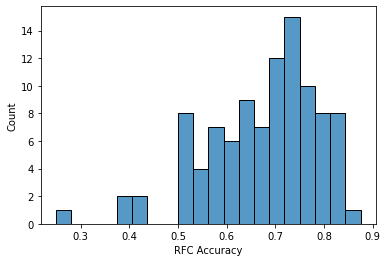

In [18]:
sns.histplot(data=df, x="RFC Accuracy", bins=20)